<a href="https://colab.research.google.com/github/MayaHayat/Decision_Trees/blob/main/Copy_of_Machine_learning__EX3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

In [50]:
x_data = []
y_data = []

with open('vectors.txt', 'r') as file:
    for line in file:
        parts = line.strip().split()
        row = [int(part) for part in parts[:8]]
        x_data.append(row)
        last_number = int(parts[-1])
        y_data.append(last_number)

# Convert the list of rows to a numpy array
x_rows = np.array(x_data)
y_rows = np.array(y_data)

Part_A Tree: {Ft : 4 {Left : {Ft : 1 {Left : Leaf : 0 , Right : Leaf : 1}} , Right : {Ft : 0 {Left : Leaf : 1 , Right : Leaf : 0}}}}
Part_A Best Error: 57 -> Accuracy :0.62
Part_B Tree: {'Ft': 3, 'Left': {'Ft': 0, 'Left': {'Leaf': 1}, 'Right': {'Leaf': 0}}, 'Right': {'Ft': 1, 'Left': {'Leaf': 0}, 'Right': {'Leaf': 1}}}
Part_B Tree's Error: 64 -> Accuracy :0.5733333333333334
Part A


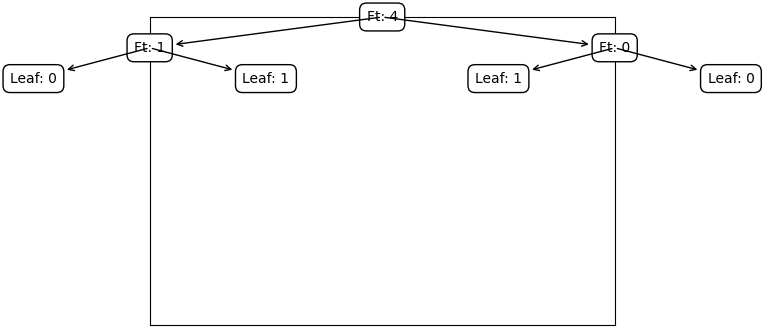

Part B


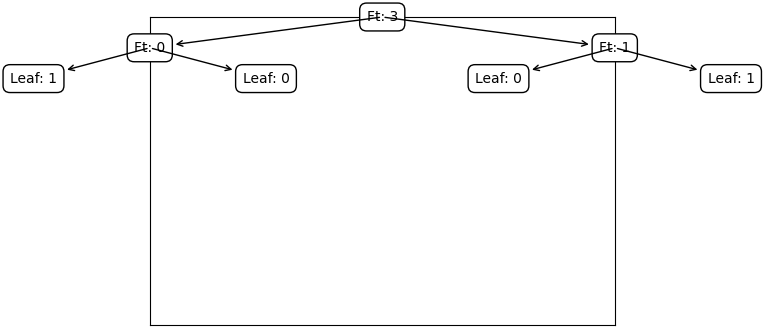

In [54]:
def format_tree(tree):
    if isinstance(tree, tuple) and len(tree) == 3:
        dim, left, right = tree
        left_str = format_tree(left)
        right_str = format_tree(right)
        return f"{{Ft : {dim} {{Left : {left_str} , Right : {right_str}}}}}"
    elif isinstance(tree, tuple):
        return f"Leaf : {''.join(map(str, tree))}"

def print_trees(trees):
    for i, tree in enumerate(trees):
        formatted_tree = format_tree(tree)
        print(f"Tree {i + 1}: {formatted_tree}")

def generate_leaf_combinations(num_leaves):
    # Generate all possible combinations of 0s and 1s for leaves
    return list(product([0, 1], repeat=num_leaves))

def generate_trees(depth, dimensions):
    def generate_node(depth):
        num_leaves = 2 ** depth
        if depth == 0:
            return [tuple(comb) for comb in generate_leaf_combinations(num_leaves)]
        else:
            trees = set()
            for dim in range(dimensions):
                left_subtrees = generate_node(depth - 1)
                right_subtrees = generate_node(depth - 1)
                for left in left_subtrees:
                    for right in right_subtrees:
                        tree = (dim, left, right)
                        trees.add(pruning(tree))
            return trees

    return generate_node(depth)

# "A node which has only vectors of one label need not be split" - remove any node splitted to the same numbers
def pruning(tree):
    if isinstance(tree, tuple) and len(tree) == 3:
        dim, left, right = tree
        left = pruning(left)
        right = pruning(right)
        if left == right:
            return left
        return (dim, left, right)
    elif isinstance(tree, tuple):
        return tree

def predict_tree(tree, vector):
    if isinstance(tree, tuple) and len(tree) == 3:
        dim, left, right = tree
        if vector[dim] == 0:
            return predict_tree(left, vector)
        else:
            return predict_tree(right, vector)
    else:
        return tree

def compute_error(y_rows, predicted):
    if len(y_rows) != len(predicted):
        raise ValueError("Predicted and expected must have the same length.")
    num_errors = 0
    for i in range(len(y_rows)):
        if predicted[i] != y_rows[i]:
            num_errors += 1
    return num_errors

def evaluate_tree(tree, vectors, labels):
    predictions = [predict_tree(tree, vector) for vector in vectors]
    return compute_error(labels, predictions)

def compute_best_tree(trees, vectors, labels):
    best_tree = None
    best_error = len(labels)
    for tree in trees:
        error = evaluate_tree(tree, vectors, labels)
        formatted_tree = format_tree(tree)
        # print(f"Error: {error}, Tree: {formatted_tree}")
        if error < best_error:
            best_error = error
            best_tree = tree
    return best_tree, best_error


k = 3
depth = k-1
dimensions = len(x_rows[0])
trees = generate_trees(depth, dimensions)
X = x_rows
y = y_rows

best_tree, best_error= compute_best_tree(trees, X, y)
formatted_tree = format_tree(best_tree)
print(f"Part_A Tree: {formatted_tree}")
print(f"Part_A Best Error: {best_error} -> Accuracy :{(len(X)- best_error)/ len(X)}")




def entropy(y):
    unique_labels, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities])

def information_gain(X, y, feature):
    original_entropy = entropy(y)
    left_X, left_y, right_X, right_y = split_data(X, y, feature)
    if len(left_y) == 0 or len(right_y) == 0:
        return 0

    left_entropy = entropy(left_y)
    right_entropy = entropy(right_y)

    p_left = len(left_y) / len(y)
    p_right = len(right_y) / len(y)
    weighted_entropy = p_left * left_entropy + p_right * right_entropy

    return original_entropy - weighted_entropy

def split_data(X, y, feature):
    threshold = np.median(X[:, feature])
    left_mask = X[:, feature] == 0
    right_mask = X[:, feature] == 1
    left_X = X[left_mask]
    left_y = y[left_mask]
    right_X = X[right_mask]
    right_y = y[right_mask]
    return left_X, left_y, right_X, right_y

def build_tree(X, y, depth, max_depth):
    if depth == max_depth or len(X) == 0 or len(set(y)) == 1:
        return {'Leaf': int(np.argmax(np.bincount(y.astype(int))))} # final leaves

    best_gain = -1
    best_feature = None
    for feature in range(X.shape[1]):
        gain = information_gain(X, y, feature)
        if gain > best_gain:
            best_gain = gain
            best_feature = feature

    left_X, left_y, right_X, right_y = split_data(X, y, best_feature)

    left_subtree = build_tree(left_X, left_y, depth + 1, max_depth)
    right_subtree = build_tree(right_X, right_y, depth + 1, max_depth)

    return {'Ft': best_feature, 'Left': left_subtree, 'Right': right_subtree}

def predict_tree(tree, vector):
    if 'Leaf' in tree:
        return tree['Leaf']
    feature = tree['Ft']
    if vector[feature] == 0:
        return predict_tree(tree['Left'], vector)
    else:
        return predict_tree(tree['Right'], vector)


X = x_rows
y = y_rows

max_depth = 2
best_tree = build_tree(X, y, 0, max_depth)

error = evaluate_tree(best_tree, X, y)

formatted_tree = format_tree(best_tree)

print(f"Part_B Tree: {best_tree}")
print(f"Part_B Tree's Error: {error} -> Accuracy :{(len(X)-error)/ len(X)}")

def plot_node(ax, node_txt, center_pt, parent_pt):
    ax.annotate(node_txt, xy=parent_pt, xycoords='axes fraction',
                xytext=center_pt, textcoords='axes fraction',
                va="center", ha="center", bbox=dict(boxstyle="round,pad=0.5", fc="w"),
                arrowprops=dict(arrowstyle="<-"))

def plot_tree(ax, tree, parent_pt, center_pt, text_offset, depth=0):
    if 'Leaf' in tree:
        node_txt = f"Leaf: {tree['Leaf']}"
    else:
        node_txt = f"Ft: {tree['Ft']}"

    plot_node(ax, node_txt, center_pt, parent_pt)

    if 'Left' in tree:
        left_center_pt = (center_pt[0] - text_offset / (2 ** depth), center_pt[1] - 0.1)
        plot_tree(ax, tree['Left'], center_pt, left_center_pt, text_offset, depth + 1)

    if 'Right' in tree:
        right_center_pt = (center_pt[0] + text_offset / (2 ** depth), center_pt[1] - 0.1)
        plot_tree(ax, tree['Right'], center_pt, right_center_pt, text_offset, depth + 1)

def draw_tree(tree):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plot_tree(ax, tree, (0.5, 1), (0.5, 1), 0.5)
    plt.show()

# Example tree
Part_A = {'Ft': 4, 'Left': {'Ft': 1, 'Left': {'Leaf': 0}, 'Right': {'Leaf': 1}}, 'Right': {'Ft': 0, 'Left': {'Leaf': 1}, 'Right': {'Leaf': 0}}}

Part_B = {'Ft': 3, 'Left': {'Ft': 0, 'Left': {'Leaf': 1}, 'Right': {'Leaf': 0}}, 'Right': {'Ft': 1, 'Left': {'Leaf': 0}, 'Right': {'Leaf': 1}}}

# Draw the tree
print("Part A")
draw_tree(Part_A)
print("Part B")
draw_tree(Part_B)
